In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Read the data
df = pd.read_csv("dataset_mood_smartphone.csv",delimiter=',')
# drop a column
df = df.drop(['Unnamed: 0'],axis=1)
# print the data
df

,id,time,variable,value
0,AS14.01,2014-02-26 13:00:00.000,mood,6.000
1,AS14.01,2014-02-26 15:00:00.000,mood,6.000
2,AS14.01,2014-02-26 18:00:00.000,mood,6.000
3,AS14.01,2014-02-26 21:00:00.000,mood,7.000
4,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
376907,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
376908,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
376909,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
376910,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Task 1A

Start with exploring the raw data that is available:

• Notice all sorts of properties of the dataset: how many records are there, how many
attributes, what kinds of attributes are there, ranges of values, distribution of values,
relationships between attributes, missing values, and so on. A table is often a suitable
way of showing such properties of a dataset. Notice if something is interesting (to you,
or in general), make sure you write it down if you find something worth mentioning.

• Make various plots of the data. Is there something interesting worth reporting? Report
the figures, discuss what is in them. What meaning do those bars, lines, dots, etc.
convey? Please select essential and interesting plots for discussion, as you have limited
space for reporting your findings.


## Remaining
Remaining - im still not able to find a good graph to showcase in this. 
Gowthams comment - most entries of appCat have a mood valence associated with its usage. 

In [26]:
# print the number of records and attributes
print(f'Number of records: {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')

# print the names and data types of the attributes
print('Attribute names and data types:')
print(df.dtypes)

# get the range of values for the 'value' column
value_range = (df['value'].min(), df['value'].max())
print('Range of Value column:', value_range)

# get the range of values for the 'time' column
time_range = (df['time'].min(), df['time'].max())
print('Range of Time column:', time_range)

# print the number of missing values for each attribute
print('Number of missing values per attribute:')
print(df.isnull().sum())

Number of records: 376912
Number of attributes: 4
Attribute names and data types:
id           object
time         object
variable     object
value       float64
dtype: object
Range of Value column: (-82798.871, 33960.246)
Range of Time column: ('2014-02-17 07:00:52.197', '2014-06-09 00:00:00.000')
Number of missing values per attribute:
id            0
time          0
variable      0
value       202
dtype: int64


In [29]:
df.describe()

,value
count,376710.000000
mean,40.665313
std,273.726007
min,-82798.871000
25%,2.025000
50%,7.029000
75%,29.356000
max,33960.246000


In [43]:
df.shape

(376912, 4)

In [42]:
#number of unique values
df.nunique()

id              27
time        336907
variable        19
value       130606
dtype: int64

In [32]:
#skewness and kurtosis
print("Skewness: %f" % df['value'].skew())
print("Kurtosis: %f" % df['value'].kurt())

Skewness: -32.064213
Kurtosis: 26063.604831


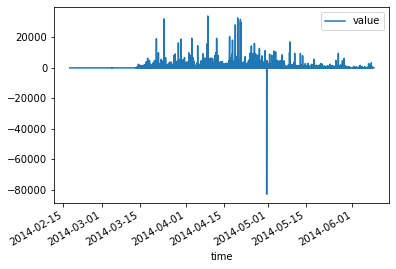

In [38]:
# convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# plot a line graph of 'value' vs 'time'
df.plot(x='time', y='value', kind='line')

# show the plot
plt.show()

In [50]:
# something interesting is that there are some duplicated timestamp need to explore more on that
# there is a negative value on one day throughout a dataset, huge value.
# some values are even missing. 

In [57]:
# group the data by participant and time, and calculate the mean mood value for each group
grouped = df.groupby(['variable']).mean().reset_index()

print(grouped.sort_values('value',ascending=False))

                variable       value
5            appCat.game  128.391615
17                screen   75.335206
8          appCat.social   72.401906
9          appCat.travel   45.730850
10        appCat.unknown   45.553006
2   appCat.communication   43.343792
3   appCat.entertainment   37.576480
7           appCat.other   25.810839
6          appCat.office   22.578892
4         appCat.finance   21.755251
12        appCat.weather   20.148714
1         appCat.builtin   18.538262
11      appCat.utilities   18.537552
16                  mood    6.992555
18                   sms    1.000000
13                  call    1.000000
15    circumplex.valence    0.687808
0               activity    0.115958
14    circumplex.arousal   -0.098624


In [ ]:
#this shows that poeple have spend time on games more (Duration of usage of game apps (time))

In [63]:
data_monthly = df[['time','value']]
# create a new column 'monthly_date' with monthly date values
data_monthly['monthly_date'] = data_monthly['time'].dt.to_period('M')
grouped_time_monthly = data_monthly.groupby(['monthly_date']).sum().reset_index()
print(grouped_time_monthly.sort_values('value',ascending=False))

  monthly_date         value
2      2014-04  9.445997e+06
1      2014-03  3.054395e+06
3      2014-05  2.751413e+06
4      2014-06  6.609723e+04
0      2014-02  1.128000e+03


/var/folders/gj/jkkdm3g53912l5m4ptkm88pc0000gn/T/ipykernel_82848/2487609544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_monthly['monthly_date'] = data_monthly['time'].dt.to_period('M')


In [64]:
# this shows in 2014 April the value is highest.

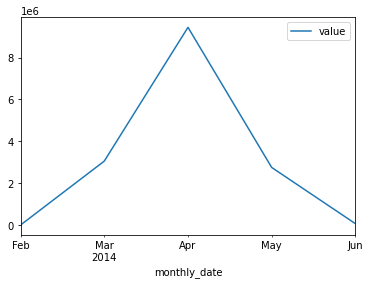

In [65]:
# plot a line graph of 'value' vs 'time'
grouped_time_monthly.plot(x='monthly_date', y='value', kind='line')

# show the plot
plt.show()

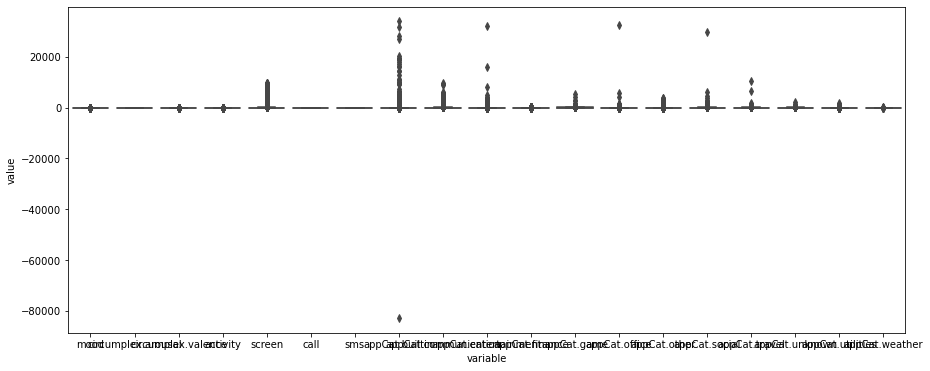

In [73]:
#box plot overallqual/saleprice
data = pd.concat([df['variable'], df['value']], axis=1)
f, ax = plt.subplots(figsize=(15, 6))
fig = sns.boxplot(x='variable', y="value", data=data)

# Task 1B


As the insights from Task 1A will have shown, the dataset you analyze contains quite some
noise. Values are sometimes missing, and extreme or incorrect values are seen that are likely
outliers youmay want to remove from the dataset. We will clean the dataset in two steps:

• Apply an approach to remove extreme and incorrect values fromyour dataset. Describe
what your approach is, why you consider that to be a good approach, and describe what
the result of applying the approach is.

• Impute the missing values using two different approaches. Describe the approaches
and study the impact of applying them to your data. Argue which one of the two approacheswould
be most suitable and select that one to formyour cleaned dataset. Also
base yourself on scientific literature for making your choice.
Advanced: The advanced dataset contains a number of time series, select approaches to impute
missing values that are logical for such time series. Also consider what to do with prolonged
periods of missing data in a time series.